##  data preprocessing and model training/test/evaluaion

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings('ignore')
%matplotlib inline

card_df = pd.read_csv('/creditcard/creditcard.csv')
card_df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


We can't know what the features' names mean  
Time label was used just for creating datas. So we are going to drop this label.  
Amount label: creditcard transaction amount  
Class: label data. 1:fraud, 0:normal

In [2]:
from sklearn.model_selection import train_test_split

#copy df, drop Time column and copied return df
def get_preprocessed_df(df=None):
    df_copy = df.copy() #copy method
    df_copy.drop('Time', axis=1, inplace=True)
    return df_copy

In [3]:
#return training data and test data after data preprocessing
def get_train_test_dataset(df=None):
    df_copy = get_preprocessed_df(df)
    X_features = df_copy.iloc[:,:-1]
    y_target = df_copy.iloc[:,-1]
    
    #train_test_split() , stratify=y_target : split based Stratified
    X_train, X_test, y_train, y_test = train_test_split(X_features, y_target, test_size=0.3, random_state=0, stratify=y_target)
    
    return X_train, X_test, y_train, y_test
    
X_train, X_test, y_train, y_test = get_train_test_dataset(card_df)

In [4]:
print('원본데이터레이블값비율:')
print(card_df['Class'].value_counts()/card_df['Class'].shape[0]*100)

print('학습데이터레이블값비율:')
print(y_train.value_counts()/y_train.shape[0]*100)
print('test data 레이블값비율:')
print(y_test.value_counts()/y_test.shape[0]*100)

원본데이터레이블값비율:
0    99.827251
1     0.172749
Name: Class, dtype: float64
학습데이터레이블값비율:
0    99.827451
1     0.172549
Name: Class, dtype: float64
test data 레이블값비율:
0    99.826785
1     0.173215
Name: Class, dtype: float64


logistic regression과 light gbm 기반 모델 생성

In [5]:

from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_auc_score

def get_clf_eval(y_test, pred=None, pred_proba=None):
    confusion = confusion_matrix( y_test, pred)
    accuracy = accuracy_score(y_test , pred)
    precision = precision_score(y_test , pred)
    recall = recall_score(y_test , pred)
    f1 = f1_score(y_test,pred)
    # ROC-AUC 추가 
    roc_auc = roc_auc_score(y_test, pred_proba)
    print('오차 행렬')
    print(confusion)
    # ROC-AUC print 추가
    print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f},\
    F1: {3:.4f}, AUC:{4:.4f}'.format(accuracy, precision, recall, f1, roc_auc))

In [6]:
from sklearn.linear_model import LogisticRegression

lr_clf = LogisticRegression()
lr_clf.fit(X_train, y_train)
lr_pred = lr_clf.predict(X_test)
lr_pred_proba = lr_clf.predict_proba(X_test)[:, 1]

# 3장에서 사용한 get_clf_eval() 함수를 이용하여 평가 수행. 
get_clf_eval(y_test, lr_pred, lr_pred_proba)

오차 행렬
[[85282    13]
 [   56    92]]
정확도: 0.9992, 정밀도: 0.8762, 재현율: 0.6216,    F1: 0.7273, AUC:0.9582


In [7]:
#반복되는 학습/예측/평가 위한 함수
def get_model_train_eval(model, ftr_train=None, ftr_test=None, tgt_train=None, tgt_test=None):
    model.fit(ftr_train, tgt_train)
    pred = model.predict(ftr_test)
    pred_proba = model.predict_proba(ftr_test)[:,1]
    get_clf_eval(tgt_test, pred, pred_proba)

In [8]:
from lightgbm import LGBMClassifier

lgbm_clf = LGBMClassifier(n_estimators=1000, num_leaves=64, n_jobs=-1, boost_from_average=False)
get_model_train_eval(lgbm_clf, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train, tgt_test=y_test)

오차 행렬
[[85290     5]
 [   36   112]]
정확도: 0.9995, 정밀도: 0.9573, 재현율: 0.7568,    F1: 0.8453, AUC:0.9790


logistic회귀보다는 조금 더 나은 결과

### data 분포도 변환 후 학습/예측/평가

Amount feature - 중요 feature

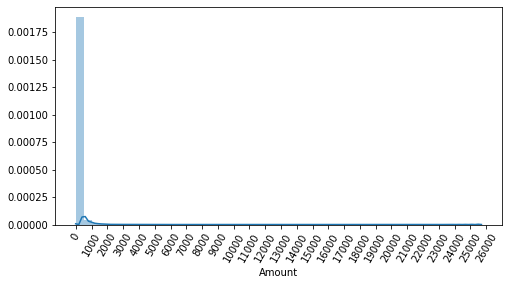

In [9]:
import seaborn as sns
plt.figure(figsize=(8, 4))
plt.xticks(range(0, 30000, 1000), rotation=60)#rotation:angle in degrees, 'vertical', 'horizontal':text 각도
sns.distplot(card_df['Amount'])

1000불 이하 데이터가 대부분이다. 긴꼬리곡선.
ligistic regression : linear model : 자료의 표준정규분포 원함

In [10]:
from sklearn.preprocessing import StandardScaler
#Amount feature값 정규분포형태로
def get_preprocessed_df(df=None):
    df_copy = df.copy()
    scaler = StandardScaler()
    amount_n = scaler.fit_transform(df_copy['Amount'].values.reshape(-1,1))
    
    #변환된 Amount -> Amount_Scaled 피쳐명 변경, Data Frame 맨 앞 column으로 입력
    df_copy.insert(0, 'Amount_Scaled', amount_n)
    
    df_copy.drop(['Time', 'Amount'], axis=1, inplace=True)
    return df_copy

In [11]:
#logistic regression and lightgbm
X_train, X_test, y_train, y_test = get_train_test_dataset(card_df)

print('###로지스틱 회귀 성능###')
lr_clf = LogisticRegression()
get_model_train_eval(lr_clf, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train, tgt_test=y_test)

print('###LightGBM 예측 성능###')
lgbm_clf = LGBMClassifier(n_estimators=1000, num_leaves=64, n_jobs=-1, boost_from_average=False)
get_model_train_eval(lgbm_clf, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train, tgt_test=y_test)

###로지스틱 회귀 성능###
오차 행렬
[[85281    14]
 [   58    90]]
정확도: 0.9992, 정밀도: 0.8654, 재현율: 0.6081,    F1: 0.7143, AUC:0.9702
###LightGBM 예측 성능###
오차 행렬
[[85290     5]
 [   37   111]]
정확도: 0.9995, 정밀도: 0.9569, 재현율: 0.7500,    F1: 0.8409, AUC:0.9779


큰 개선은 X -> log변환을 해보자

In [12]:
def get_preprocessed_df(df=None):
    df_copy = df.copy()
    #numpy log1p() 이용해 Amount log변환
    amount_n  = np.log1p(df_copy['Amount'])
    df_copy.insert(0, 'Amount_Scaled', amount_n)
    df_copy.drop(['Time', 'Amount'], axis=1, inplace=True)
    return df_copy

In [13]:
X_train, X_test, y_train, y_test = get_train_test_dataset(card_df)

print('### 로지스틱 회귀 예측 성능 ###')
get_model_train_eval(lr_clf, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train, tgt_test=y_test)

print('### LightGBM 예측 성능 ###')
get_model_train_eval(lgbm_clf, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train, tgt_test=y_test)


### 로지스틱 회귀 예측 성능 ###
오차 행렬
[[85283    12]
 [   59    89]]
정확도: 0.9992, 정밀도: 0.8812, 재현율: 0.6014,    F1: 0.7149, AUC:0.9727
### LightGBM 예측 성능 ###
오차 행렬
[[85290     5]
 [   35   113]]
정확도: 0.9995, 정밀도: 0.9576, 재현율: 0.7635,    F1: 0.8496, AUC:0.9796


어느정도 개선되었음. 정밀도, 재현율, roc-auc에서 약간씩 개선

### outlier 제거 후 학습/예측/평가

많은피쳐->결정값(레이블)과 가장 상관성이 높은 피쳐들 위주로 이상치 검출 하는 것이 좋다.  
이상치 검출에는 시간이 많이 소모되는데 결정값과 상관성이 높지않은 피쳐들은 이상치를 제거해도 크게 성능이 향상되지 않기 때문이다.

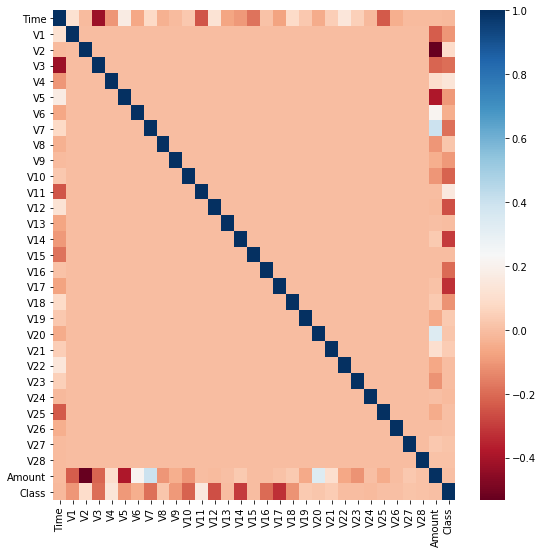

In [14]:
#dataframe의 corr() 로 피쳐별 상관도 구해서 seaborn 의 heatmap으로 시각화
import seaborn as sns

plt.figure(figsize=(9,9))
corr = card_df.corr()
sns.heatmap(corr, cmap='RdBu')#RdBu: 상관관계높을수록진한빨간색에가깝게

V14, V17이 Class값과 음의 상관관계 가장 큼

In [15]:
#outlier 겁출 함수
import numpy as np

def get_outlier(df=None, column=None, weight=1.5):
    #fraud에 해당하는 column만 추출하고 1/4, 3/4분위 지점을 np.percentile로 구함
    fraud=df[df['Class']==1][column]
    quantile_25 = np.percentile(fraud.values, 25)
    quantile_75 = np.percentile(fraud.values, 75)
    #IQR계산해 1.5곱한 값 이용해 최댓값 최솟값 지점 구함
    iqr = quantile_75 - quantile_25
    iqr_weight = iqr * weight
    lowest_val = quantile_25 - iqr_weight
    highest_val = quantile_75 + iqr_weight
    
    outlier_index = fraud[(fraud < lowest_val) | (fraud > highest_val)].index
    return outlier_index

In [16]:
outlier_index = get_outlier(df=card_df, column='V14', weight=1.5)
print('이상치 데이터 인덱스:', outlier_index)

이상치 데이터 인덱스: Int64Index([8296, 8615, 9035, 9252], dtype='int64')


In [17]:
#로그변환 후 V14 피쳐 이상치 데이터 삭제 로직
def get_preprocessed_df(df=None):
    df_copy = df.copy()
    amount_n = np.log1p(df_copy['Amount'])
    df_copy.insert(0, 'Amount_Scaled', amount_n)
    df_copy.drop(['Time', 'Amount'], axis=1, inplace=True)
    #이상치삭제
    outlier_index = get_outlier(df=df_copy, column='V14', weight=1.5)
    df_copy.drop(outlier_index, axis=0, inplace=True)
    return df_copy

X_train, X_test, y_train, y_test = get_train_test_dataset(card_df)
print('### 로지스틱 회귀 예측 성능 ###')
get_model_train_eval(lr_clf, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train, tgt_test=y_test)
print('### LightGBM 예측 성능 ###')
get_model_train_eval(lgbm_clf, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train, tgt_test=y_test)


### 로지스틱 회귀 예측 성능 ###
오차 행렬
[[85281    14]
 [   48    98]]
정확도: 0.9993, 정밀도: 0.8750, 재현율: 0.6712,    F1: 0.7597, AUC:0.9743
### LightGBM 예측 성능 ###
오차 행렬
[[85290     5]
 [   25   121]]
정확도: 0.9996, 정밀도: 0.9603, 재현율: 0.8288,    F1: 0.8897, AUC:0.9780


### SMOTE Oversampling and model train/test/evaluation

In [19]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=0)
X_train_over, y_train_over = smote.fit_sample(X_train, y_train)
print('SMOTE 적용 전 학습용 피쳐/레이블 세트: ', X_train.shape, y_train.shape)
print('SMOTE 적용 후 학습용 피처/레이블 데이터 세트: ', X_train_over.shape, y_train_over.shape)
print('SMOTE 적용 후 레이블 값 분포: \n', pd.Series(y_train_over).value_counts())

SMOTE 적용 전 학습용 피쳐/레이블 세트:  (199362, 29) (199362,)
SMOTE 적용 후 학습용 피처/레이블 데이터 세트:  (398040, 29) (398040,)
SMOTE 적용 후 레이블 값 분포: 
 1    199020
0    199020
Name: Class, dtype: int64


In [20]:
lr_clf = LogisticRegression()
# ftr_train과 tgt_train 인자값이 SMOTE 증식된 X_train_over와 y_train_over로 변경됨에 유의
get_model_train_eval(lr_clf, ftr_train=X_train_over, ftr_test=X_test, tgt_train=y_train_over, tgt_test=y_test)

오차 행렬
[[82937  2358]
 [   11   135]]
정확도: 0.9723, 정밀도: 0.0542, 재현율: 0.9247,    F1: 0.1023, AUC:0.9737


너무 낮은 정밀도 : 지나치게 많이 1로 예측

In [23]:
#임계값 따른 정밀도와 재현율 그래프 함수
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.metrics import precision_recall_curve
%matplotlib inline

def precision_recall_curve_plot(y_test , pred_proba_c1):
    # threshold ndarray와 이 threshold에 따른 정밀도, 재현율 ndarray 추출. 
    precisions, recalls, thresholds = precision_recall_curve( y_test, pred_proba_c1)
    
    # X축을 threshold값으로, Y축은 정밀도, 재현율 값으로 각각 Plot 수행. 정밀도는 점선으로 표시
    plt.figure(figsize=(8,6))
    threshold_boundary = thresholds.shape[0]
    plt.plot(thresholds, precisions[0:threshold_boundary], linestyle='--', label='precision')
    plt.plot(thresholds, recalls[0:threshold_boundary],label='recall')
    
    # threshold 값 X 축의 Scale을 0.1 단위로 변경
    start, end = plt.xlim()
    plt.xticks(np.round(np.arange(start, end, 0.1),2))
    
    # x축, y축 label과 legend, 그리고 grid 설정
    plt.xlabel('Threshold value'); plt.ylabel('Precision and Recall value')
    plt.legend(); plt.grid()
    plt.show()
    

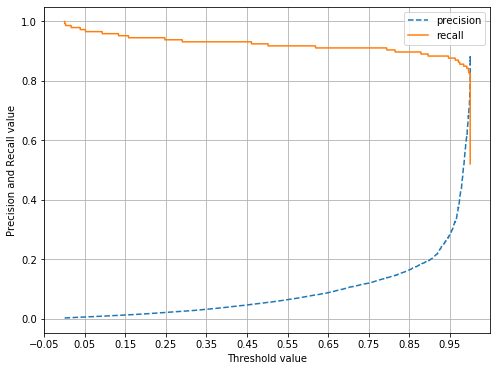

In [22]:
precision_recall_curve_plot( y_test, lr_clf.predict_proba(X_test)[:, 1] )

두 값다 어느 지점에서 급격한 변화 : 임계값 민감도가 너무 심해 올바른 재현도/정밀도 성능을 얻을수가없다.  
logistic회귀로는 SMOTE 적용 후 올바른 예측 모델 생성하지 못했다.

#### lightgbm

In [24]:

lgbm_clf = LGBMClassifier(n_estimators=1000, num_leaves=64, n_jobs=-1, boost_from_average=False)
get_model_train_eval(lgbm_clf, ftr_train=X_train_over, ftr_test=X_test,
                  tgt_train=y_train_over, tgt_test=y_test)

오차 행렬
[[85283    12]
 [   22   124]]
정확도: 0.9996, 정밀도: 0.9118, 재현율: 0.8493,    F1: 0.8794, AUC:0.9814


보통 SMOTE 결과로  정밀도는 낮아지고 재현율은 증가한다